<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Finance Course

**Module 4 &mdash; Simulation**

[team@tpq.io](mailto:team@tpq.io) | [http://tpq.io](http://tpq.io)

The Python Quants GmbH

## Requirements

Make sure to have installed locally a **comprehensive Python installation** like the [Anaconda](http://continuum.io/downloads) Python distribution.

Alternatively, and more easily, register on the **[Quant Platform](http://pqp.io)** where you can execute this Jupyter Notebook file in the browser. After registration, you find all Jupyter Notebook files of this course in the folder `pffcourse`.

## Necessary Imports

As usual, we need to **import certain modules/packages**.

In [1]:
import numpy as np  # array operations
import pandas as pd  # time series management
from pandas_datareader import data as web  # data retrieval
import matplotlib.pyplot as plt  # standard plotting library
import seaborn as sns; sns.set()  # nicer plotting style
# put all plots in the notebook itself
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

## Retrieving Stock Price Data

This module is about the **Mote Carlo simulation** of a stock price process for the purpose of e.g. valuing a European option on the stock. We start by **retrieving some stock price data** as a starting point for our endeavor.

In [2]:
sym = 'AAPL'  # our symbol
data = pd.DataFrame()  # empty DataFrame
data[sym] = web.DataReader(sym, data_source='yahoo', start='2014-1-1')['Adj Close']

Let us inspect the **final five rows** of the `DataFrame` object.

In [3]:
data.tail()  # the final five rows

,AAPL
Date,
2016-12-08,112.120003
2016-12-09,113.949997
2016-12-12,113.300003
2016-12-13,115.190002
2016-12-14,115.190002


The **graphical representation** of our data.

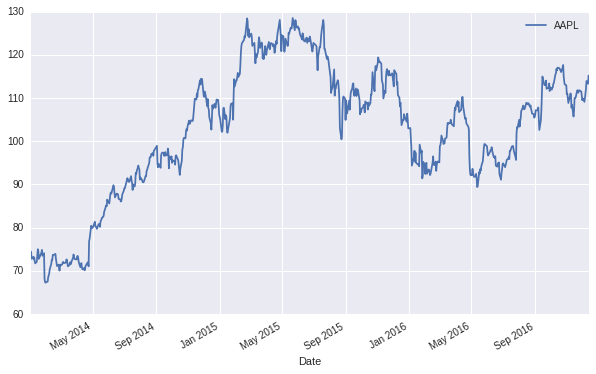

In [4]:
data.plot(figsize=(10, 6));

## Basic Statistics

The first step in the calculation of the **annualized stock return and volatility** is the calculation of the **daily log returns**.

In [5]:
# vectorized calculation of the log returns
log_rets = np.log(data / data.shift(1))

From these, we get our desired measures.

In [6]:
# annualized average log returns
mu = log_rets.mean() * 252
mu

AAPL    0.14789
dtype: float64

In [7]:
# annualized volatility
sigma = log_rets.std() * 252 ** 0.5
sigma

AAPL    0.241716
dtype: float64

## Stock Price Model

To model the stochastic evolution of the stock price, we use the **geometric Brownian motion** as in Black-Merton-Scholes (1973). The stochastic differential equation (SDE) is given by

$$
dS_t = \mu S_t dt + \sigma  S_t dZ_t
$$

with

* $S_t$ being the stock price at date $t$
* $\mu$ being the average return of the stock (drift)
* $\sigma$ the volatility
* $Z_t$ a standard Brownian motion

An Euler discretization scheme is given by

$$
S_t = S_{t-\Delta t} e^{ \left( \mu-\frac{1}{2}\sigma^2 \right)\Delta t + \sigma \sqrt{\Delta t} z_t}
$$

with $\Delta t$ a fixed time interval and $z_t$ a standard normally distributed random variable.

## Monte Carlo Simulation

Let us now translate the theory into practical Python code. First, some **parametrizations**.

In [8]:
S0 = data.ix[-1]  # final value = initial value
sigma = sigma.values[0]  # volatility of the stock
mu = mu.values[0]  # average return
T = 1.0  # horizon 1 year
M = 252  # number of time intervals
dt = T / M  # fixed length time interval
I = 20000  # number of simulated paths

Next, the **simulation routine** itself.

In [9]:
rand = np.random.standard_normal((M + 1, I))  # radnom number array
S = np.zeros_like(rand)  # array for stock prices
S[0] = S0  # all paths start at initial value
for t in xrange(1, M + 1):
    S[t] = S[t-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * dt ** 0.5 * rand[t])

Let us **plot** a selection of the simulated paths.

(0, 252)

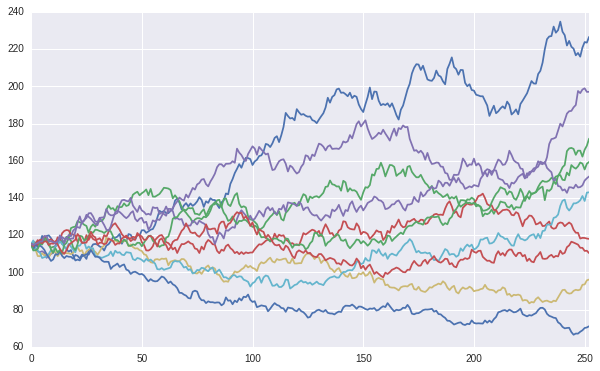

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(S[:, :10]);
plt.xlim(0, M)

Let us **add the history** as well.

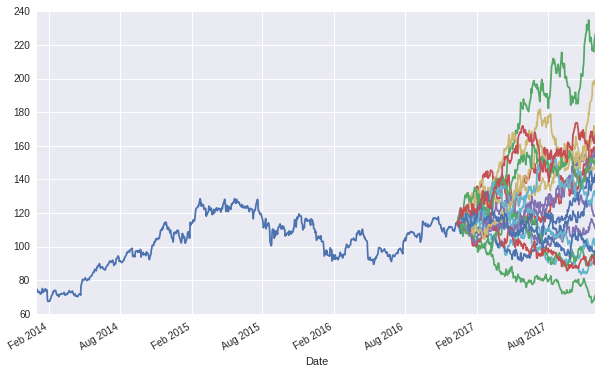

In [11]:
index = pd.date_range(start=data.index[-1], periods=M + 1, freq='B')
ax = data.plot(figsize=(10, 6), legend=False);
pd.DataFrame(S[:, :20], index=index).plot(ax=ax, legend=False);

## Option Pricing

In order to price options by Monte Carlo simulation, we need to **simulate the stochastic process with the drift $\mu$ replaced by the risk-less short rate $r$** (according to the Fundamental Theorem of Asset Pricing).

In [12]:
r = 0.01  # risk-less short rate
for t in xrange(1, M + 1):
    S[t] = S[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * dt ** 0.5 * rand[t])

Having the simulated stock price paths with risk-neutral drift available makes the **pricing of European options** straightforward. We want today price a European call option with strike 110 maturing after 1 year. First, the **payoff of the option at maturity**.

In [13]:
# vectorized payoff calculation
payoff = np.maximum(S[-1] - 110, 0)

The payoff as a **histogram**: as is quite common, the option expires worthless in a large number of cases.

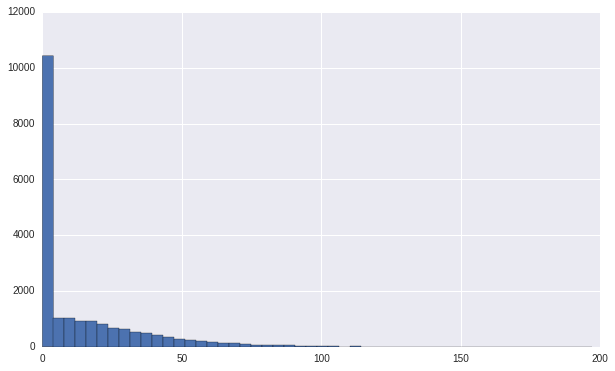

In [14]:
plt.figure(figsize=(10, 6));
plt.hist(payoff, bins=50);

Since we have simulated the paths now with a drift equal to the risk-less short rate, we can simply **estimate the price of the option by taking the average payoff value and discounting it back to today**.

In [15]:
C0 = np.exp(-r * T) * np.sum(payoff) / I
C0  # estimated call option price

14.060047492005312

## Closing Remarks

This finishes the fourth module of the Python for Finance email course. In this module, you have learned:

* how to calculate basic statistics for stock price time series
* how to simulate the geometric Brownian motion given the basic statistics
* how to visualize the simulated stock price paths
* how to simulate the stochastic process in risk-neutral fashion
* how to calculate option payoffs at maturity given the simulated stock price paths
* how to estimate the price of a European call option by Monte Carlo simulation

The simulation techniques introduced in this module are of paramount importance not only in derivatives analytics but also, for example, in risk management.

## Exercises

In order to master the material of this module, do the following:

* work with a different symbol
* estimate the value of a European put option with the same parameters
* estimate the values of European call/put options for a wide range of strikes
* estimate the values for European options with more exotic payoffs (e.g. lookback features)
* replace the geometric Brownian motion model by a more realistic one with jumps and/or stochastic volatility
* go through the documentation of the library [DX Analytics](http://dx-analytics.com) to learn more about derivatives analytics with Python

## References

You find background information for the topics covered in this module in the following books:

* Hilpisch, Yves (2014): _Python for Finance_. O'Reilly, ch. 10.
* Hilpisch, Yves (2015): _Derivatives Analytics with Python_. Wiley Finance.

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

**Quant Platform** |
<a href="http://quant-platform.com">http://quant-platform.com</a>

**Python for Finance** |
<a href="http://python-for-finance.com" target="_blank">Python for Finance @ O'Reilly</a>

**Derivatives Analytics with Python** |
<a href="http://derivatives-analytics-with-python.com" target="_blank">Derivatives Analytics @ Wiley Finance</a>

**Listed Volatility and Variance Derivatives** |
<a href="http://lvvd.tpq.io" target="_blank">Listed VV Derivatives @ Wiley Finance</a>